In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pylab 
import statistics as stats
import scipy.stats as scipy
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import os

In [4]:
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))


housedf = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [129]:
# Creating the for loop to take care of all missing values in object columns.
column = (['poolqc', 'fence', 'miscfeature', 'alley', 'fireplacequ', 'garagecond', 'garagetype', 'garagefinish', 'garagequal', 
            'bsmtexposure', 'bsmtfintype2', 'bsmtfintype1', 'bsmtcond', 'bsmtqual', 'masvnrtype', 'electrical'])

for col_name in column:
   housedf[col_name].fillna('blank', inplace= True)

In [6]:
  # Since this feature has a min. value of 0 it won't hurt if I turn all missing values to a 0 as well
housedf['masvnrarea'].fillna(0, inplace= True)

In [7]:
# Since the remaining two features only have a minimal number of null values and can't be set to 0 I'm going to set them to 
# the average of the column.

housedf['lotfrontage'].fillna(housedf['lotfrontage'].mean(),inplace=True)
housedf['garageyrblt'].fillna(housedf['garageyrblt'].mean(),inplace=True)


In [8]:
#Borrowed this piece of code and the one below from the example: these are designed to help seperate columns faster!
non_numeric_columns = housedf.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [9]:
numeric_columns = housedf.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [19]:
# Adding new feature to our model
X = housedf[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']] 
Y = housedf.saleprice

In [12]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     926.5
Date:                Wed, 03 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:27:33   Log-Likelihood:                -17499.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1454   BIC:                         3.504e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.907e+04   4638.450    -21.359      0.000   -1.08e+05      -9e+04
overallqual  2.364e+04   1072.532     22.037      0.000    2.15e+04    2.57e+04
grlivarea      45.3458      2.489     18.218      0.000      40.463      50.228
garagecars   1.454e+04   3022.681      4.812      0.000    8615.034    2.05e+04
garagearea     17.1334     10.468      1.637      0.102      -3.401      37.668
totalbsmtsf    31.5015      2.904     10.848      0.000      25.805      37.198
==============================================================================
Omnibus:                      438.146   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40648.199
Skew:                          -0.338   Prob(JB):                         0.00
Kurtosis:                      28.841   Cond. No.                     9.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# Let's make our model
X = housedf[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf']] 
Y = housedf.saleprice

In [14]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1156.
Date:                Wed, 03 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:41:50   Log-Likelihood:                -17500.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1455   BIC:                         3.504e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.925e+04   4639.866    -21.390      0.000   -1.08e+05   -9.01e+04
overallqual  2.357e+04   1072.465     21.980      0.000    2.15e+04    2.57e+04
grlivarea      45.6432      2.484     18.376      0.000      40.771      50.515
garagecars   1.858e+04   1747.412     10.634      0.000    1.52e+04     2.2e+04
totalbsmtsf    32.5203      2.838     11.459      0.000      26.953      38.087
==============================================================================
Omnibus:                      421.692   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36798.858
Skew:                          -0.273   Prob(JB):                         0.00
Kurtosis:                      27.589   Cond. No.                     8.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Questions:
** 1. Which features are statistically significant and which aren't?**
Using p-value of the features it's easy to see that garage area, which has a p-value of 0.102, is not really related to the price of houses. The remaining four features (overall quality, above ground living area, the number of cars a garage holds, and total basement square feet) all have a p-value of close to 0 so they are statistically significant!

**2. Exclude the insignificant features. Did anything change?**
Yes! The p-value for the remaining 4 features stayed the same, but the coefficients for garage cars and basement square feet changed.


**3. Interpert the statistically significant  coefficients by quantifying their relations with house prices. Which features have a more prominent effect on house prices?**


**4. Do the results sound reasonable to you? If not, try to explain.** 

## Check Point 19.5

Questions: 
1. Looking at R-squared, adjusted R-squared, AIC, and BIC discuss goodness of fit.
Looking at the first model in which I have five features my R-squared is 0.761 and my adjusted R-Squared is 0.760 meaning that my model explains about 76% of variation in the outcome. Not too bad! It could improve some, which I plan on doing in the model iterations below. I will discuss AIC/BIC once I have other models to compare it to!

2. Do you think your model is satisfactory? Why?
My first model isn't too bad, but there is still 24% of variance that is unexplained. I hope that I can improve on this model with my future feature engineering!

3. Try adding or removing variables to see what happens.
4. For each model I try, get the goodness of fit metrics and compare your models with each other. Which model is the best and why?

Using the information above I created two more models below (model 2 and model 3, respectively). Using the four features I looked first at how they were correlated to see if there were any strong connections I could use to create a new interaction feature. The largest correlation was between overall quality and number of cars in garage, so I ran my second model using this interaction. This model performed better than my original- it's adjusted R-squared value was 0.799 and it had an AIC of 3.47x10^4. 

Next, I decided to try the second strongest correlation, quality and general living area. This model preformed slightly better than my original model (adjusted R-squared of 0.776 and AIC of 3.492 x 10^4) but did not preform better than my second model. With this information I would, if I was going to work on these models further, keep model 2 and continue to engineer features to see if I could improve my adjusted R-squared value!

In [15]:
# Let's make some interaction features! First, let's do a correlation matrix of just these 4 features.
X.corr()

,const,overallqual,grlivarea,garagecars,totalbsmtsf
const,NaN,NaN,NaN,NaN,NaN
overallqual,NaN,1.000000,0.593007,0.600671,0.537808
grlivarea,NaN,0.593007,1.000000,0.467247,0.454868
garagecars,NaN,0.600671,0.467247,1.000000,0.434585
totalbsmtsf,NaN,0.537808,0.454868,0.434585,1.000000


#### Model 2

In [31]:
# Creating a new feature for the interaction of overall quality and number of cars
housedf['quality_and_cars'] = housedf['overallqual'] * housedf['garagecars']

In [32]:
X = housedf[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'quality_and_cars']] 
Y = housedf.saleprice

In [33]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1153.
Date:                Wed, 03 Jul 2019   Prob (F-statistic):               0.00
Time:                        17:27:21   Log-Likelihood:                -17374.
No. Observations:                1460   AIC:                         3.476e+04
Df Residuals:                    1454   BIC:                         3.479e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.279e+04   1.01e+04      5.210      0.000    3.29e+04    7.27e+04
overallqual      -2805.2371   1874.404     -1.497      0.135   -6482.063     871.588
grlivarea           43.2178      2.284     18.920      0.000      38.737      47.699
garagecars       -5.741e+04   4867.199    -11.794      0.000    -6.7e+04   -4.79e+04
totalbsmtsf         25.3502      2.640      9.601      0.000      20.171      30.530
quality_and_cars  1.354e+04    819.077     16.536      0.000    1.19e+04    1.52e+04
==============================================================================
Omnibus:                      523.032   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38829.558
Skew:                          -0.767   Prob(JB):                         0.00
Kurtosis:                      28.218   Cond. No.                     2.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 3

In [28]:
# Creating a new feature for the interaction of overall quality and above ground living areas
housedf['quality_and_livingarea'] = housedf['overallqual'] * housedf['grlivarea']

In [29]:
X = housedf[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'quality_and_livingarea']] 
Y = housedf.saleprice

In [30]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     1007.
Date:                Wed, 03 Jul 2019   Prob (F-statistic):               0.00
Time:                        17:26:32   Log-Likelihood:                -17452.
No. Observations:                1460   AIC:                         3.492e+04
Df Residuals:                    1454   BIC:                         3.495e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4227.9698   1.13e+04      0.374      0.709    -1.8e+04    2.64e+04
overallqual             8099.3796   1867.015      4.338      0.000    4437.048    1.18e+04
grlivarea                -25.4931      7.529     -3.386      0.001     -40.262     -10.724
garagecars              1.994e+04   1696.630     11.752      0.000    1.66e+04    2.33e+04
totalbsmtsf               27.4834      2.793      9.841      0.000      22.005      32.962
quality_and_livingarea    10.5054      1.054      9.970      0.000       8.439      12.572
==============================================================================
Omnibus:                     1099.058   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           170920.268
Skew:                          -2.615   Prob(JB):                         0.00
Kurtosis:                      55.747   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Check Point 19.6: Making Predictions

#### Questions:

1. After splitting, training, and testing your data and making predictions discuss the goodness of fit of your model.

My evaluation of goodness of fit for my model is discussed above!


2. Predict the house prices in the test set. Is the model preformance satisfactory? Why?

My adjusted R-squared score for my test set is 0.84, which is actually better preforming than my original training data. I feel that this is a good start, but I would like my adjusted R-squared to be closer to the 90's if possible. I plan on iterating below to see if I can make any improvements. 


3. Play with your variables and see if you can improve your model. 

See below! 

In [37]:
X = housedf[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'quality_and_cars']] 
Y = housedf.saleprice

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('The number of observations in the training set is {}'.format(X_train.shape[0]))
print('The  number of observations in the test set is {}'.format(X_test.shape[0]))

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

print(results.summary())

The number of observations in the training set is 1168
The  number of observations in the test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     902.1
Date:                Wed, 03 Jul 2019   Prob (F-statistic):               0.00
Time:                        17:47:05   Log-Likelihood:                -13900.
No. Observations:                1168   AIC:                         2.781e+04
Df Residuals:                    1162   BIC:                         2.784e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

MAE of prediction is: 23658.18979018892
MSE of prediction is: 1288370011.5771213
RMSE of prediction is: 35893.87150443821
MAPE of prediction is: 14.050922780181324


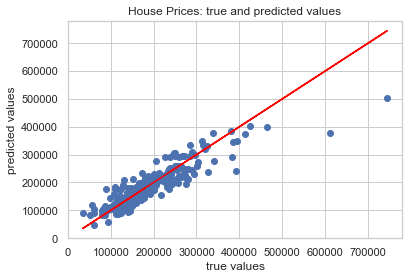

In [39]:
# Prediction time, woo!
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

# The plot thickens!
plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color ="red")
plt.xlabel("true values")
plt.ylabel('predicted values')
plt.title('House Prices: true and predicted values')


print('MAE of prediction is: {}'.format(mean_absolute_error(Y_test, Y_preds)))
print('MSE of prediction is: {}'.format(mse(Y_test, Y_preds)))
print('RMSE of prediction is: {}'.format(rmse(Y_test, Y_preds)))
print('MAPE of prediction is: {}'.format(np.mean(np.abs((Y_test - Y_preds)/Y_test)) * 100))

In [41]:
X_test = sm.add_constant(X_test)

results_pred = sm.OLS(Y_test, X_test).fit()

results_pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     273.4
Date:                Wed, 03 Jul 2019   Prob (F-statistic):          1.09e-106
Time:                        18:02:03   Log-Likelihood:                -3461.8
No. Observations:                 292   AIC:                             6936.
Df Residuals:                     286   BIC:                             6958.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.909e+04   1.95e+04      2.010      0.045     803.868    7.74e+04
overallqual      -5646.6430   3617.925     -1.561      0.120   -1.28e+04    1474.495
grlivarea           56.3019      5.034     11.183      0.000      46.393      66.211
garagecars       -6.047e+04   9390.498     -6.440      0.000    -7.9e+04    -4.2e+04
totalbsmtsf         48.8665      6.616      7.386      0.000      35.844      61.889
quality_and_cars  1.303e+04   1594.207      8.171      0.000    9888.102    1.62e+04
==============================================================================
Omnibus:                      102.528   Durbin-Watson:                   2.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              727.229
Skew:                           1.232   Prob(JB):                    1.21e-158
Kurtosis:                      10.328   Cond. No.                     2.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Prediction Set 2: Adding in More Features

In [44]:
X = housedf[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'quality_and_cars', 'firstflrsf', 'fullbath']] 
Y = housedf.saleprice

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('The number of observations in the training set is {}'.format(X_train.shape[0]))
print('The  number of observations in the test set is {}'.format(X_test.shape[0]))

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

print(results.summary())

The number of observations in the training set is 1168
The  number of observations in the test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     647.1
Date:                Thu, 04 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:48:07   Log-Likelihood:                -13897.
No. Observations:                1168   AIC:                         2.781e+04
Df Residuals:                    1160   BIC:                         2.785e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

MAE of prediction is: 23865.37961864266
MSE of prediction is: 1293214496.990425
RMSE of prediction is: 35961.291647970946
MAPE of prediction is: 14.186950823131253


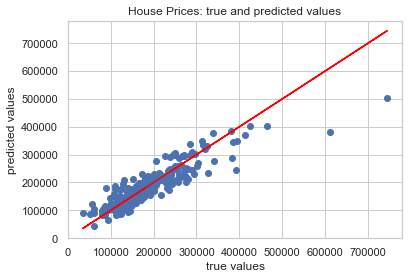

In [45]:
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

# The plot thickens!
plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color ="red")
plt.xlabel("true values")
plt.ylabel('predicted values')
plt.title('House Prices: true and predicted values')


print('MAE of prediction is: {}'.format(mean_absolute_error(Y_test, Y_preds)))
print('MSE of prediction is: {}'.format(mse(Y_test, Y_preds)))
print('RMSE of prediction is: {}'.format(rmse(Y_test, Y_preds)))
print('MAPE of prediction is: {}'.format(np.mean(np.abs((Y_test - Y_preds)/Y_test)) * 100))

In [46]:
X_test = sm.add_constant(X_test)

results_pred = sm.OLS(Y_test, X_test).fit()

results_pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     194.0
Date:                Thu, 04 Jul 2019   Prob (F-statistic):          2.83e-104
Time:                        12:48:55   Log-Likelihood:                -3461.7
No. Observations:                 292   AIC:                             6939.
Df Residuals:                     284   BIC:                             6969.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.977e+04   2.01e+04      1.977      0.049     176.816    7.94e+04
overallqual      -5958.1991   3767.718     -1.581      0.115   -1.34e+04    1457.997
grlivarea           55.4841      5.993      9.258      0.000      43.687      67.281
garagecars        -6.11e+04   9606.332     -6.360      0.000      -8e+04   -4.22e+04
totalbsmtsf         49.5251     10.186      4.862      0.000      29.475      69.575
quality_and_cars  1.311e+04   1619.865      8.090      0.000    9916.567    1.63e+04
firstflrsf          -0.6663     11.265     -0.059      0.953     -22.840      21.507
fullbath          1733.1637   5223.609      0.332      0.740   -8548.739     1.2e+04
==============================================================================
Omnibus:                      103.555   Durbin-Watson:                   2.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              738.840
Skew:                           1.245   Prob(JB):                    3.66e-161
Kurtosis:                      10.384   Cond. No.                     2.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""